# MotionTTT tutorial

In this notebook we demonstrate how to apply our proposed MotionTTT to estimate a simulated motion trajectory on an example from the [Calgary Campinas Brain MRI Dataset (CC359)](https://portal.conp.ca/dataset?id=projects/calgary-campinas#) using the pre-trained U-net from https://huggingface.co/mli-lab/Unet48-2D-CC359.

The U-net was trained on the training set from CC359 on the task of 2D reconstruction from motion-free undersampled measurements as described in [MotionTTT: 2D Test-Time-Training Motion Estimation for 3D Motion Corrected MRI](https://arxiv.org/abs/2409.09370).


#### 1. Setup data loading

Please use the notebook `prepare_CC359_dataset.ipynb` to convert the hybrid k-space from CC359 and compute the sensitivity maps. We assume the converted validation data and sensitivity maps to be located in folders `Val_converted` and `Val_s_maps_3D` respectively. Start by selecting an example from our test set and set the file paths accordingly.

In [1]:
import pickle
import os
import sys
sys.path.append('./codebase/')

from codebase.functions.utils.helpers.helpers_getargs import get_args

args = get_args()

# # Select first example from the testset
with open("codebase/data_files/volume_dataset_freqEnc170_test_len10.pickle",'rb') as fn: example_dict = pickle.load(fn)[0]
filename = example_dict["filename"]

# # Set file paths
path_to_data = "/media/ssd0/cc-359_raw/calgary-campinas_version-1.0/CC359/Raw-data/Multi-channel/12-channel" # ! adjust
path_to_result_dir = "."
results_dir = "experiments_results"
args.experiment_run_folder_name = "motionTTT_interShot_Unet48-2D-CC359"

args.example_path = f"{path_to_data}/Val_converted/{filename}"
args.mask_path= "codebase/data_files/mask_3D_size_218_170_256_R_4_poisson_disc.pickle"
args.sensmaps_path = f"{path_to_data}/Val_s_maps_3D/smaps_{filename}"

# # Load a model from huggingface:
args.model= 'unet'
args.chans= 48
args.load_model_from_huggingface = "mli-lab/Unet48-2D-CC359"


print(f"Apply motionTTT to example {filename} from the CC359 validation set using the pre-trained model from {args.load_model_from_huggingface}.")

Apply motionTTT to example e14691s3_P06656.7.h5 from the CC359 validation set using the pre-trained model from mli-lab/Unet48-2D-CC359.


#### 2. Setup parameters for simulated motion and sampling trajectory

In this example we consider inter-shot motion with 5 motion events and a maximum possible rotations/translations in [-5,+5]. We generate a motion trajectory that is unique to this test example by using the seed stored in `example_dict`.

We assume the k-space was acquired within 50 shots and with an interleaved Cartesian sampling trajectory, where the center k-space was acquired in the first shot. 

In [2]:
# # Define motion trajectory
args.motionTraj_simMot = "uniform_interShot_event_model" 
args.Ns = 50 # Number of initial motion states (must be equal to the number of shots)
args.num_shots = 50
args.num_motion_events = 5
args.max_trans = 5
args.max_rot = 5
args.random_motion_seed = example_dict["motion_seeds"]["seed1"]

# # Define sampling trajectory
args.sampTraj_simMot = "interleaved_cartesian"
args.center_in_first_state = True

#### 3. Setup the optimization scheme of MotionTTT

**Phase 1**: Obtain an initial estimate of one set of motion parameters (3 rotations, 3 translations) per shot. Start with a large learning rate and decay twice. Run for 70 steps.

**Phase 2**: Reset motion parameters of shots with a data consistency loss larger than a certain threshold to the average between the previous and next motion state that fall below the threshold. Then optimize only over the reset motion parameters for 30 steps. If no motion parameters to reset continue with phase 1 until `num_steps_TTT` is reached.

**Phase 3**: If motion parameters have been reset in phase 2, phase 3 again optimizes over all motion parameters for another 30 steps with a small learning rate. 

In [3]:
args.TTT = True

# Optimizer
args.TTT_optimizer = 'Adam'
# Total number of steps
args.num_steps_TTT= 130 
# Randomly sample the axis for 2D reconstruction in each step
args.TTT_all_axes= True 
# Clamp motion parameters during first steps
args.TTT_use_clamp_schedule = True
# Number randomly slected of slices for which gradients are backpropagated in each step
args.num_slices_per_grad_step= 5
# Do not estimate motion parameters for the first shot (reference orientation)
args.fix_mot_maxksp_shot = True 
# Use density compensation adjoint nufft with density compensation
args.TTT_use_nufft_with_dcomp = True 

# # Phase 1 parameters
args.lr_TTT= 4.0 
args.TTT_lr_max_decays = 3
args.TTT_lr_decay_factor = 0.25
args.TTT_lr_decay_at_the_latest = [39,59,1000]
args.TTT_num_rot_only_grad_steps = 5

# # Phase 2 parameters
args.TTT_list_of_split_steps = [71]
args.TTT_states_per_split = 1
args.TTT_lr_after_split = 0.5
args.TTT_DCloss_th_split = 0.575

# # Phase 3 parameters
args.TTT_optimize_all_states_after = 100
args.TTT_optimize_all_states_after_lr = 0.05

#### 4. Setup GPU usage

Specify gpu device index and the two parameters that control the gpu memory consumption `TTT_motState_batchSize_per_backprop` and `TTT_nufft_max_coil_size`:
- `TTT_nufft_max_coil_size`: The (adjoint) NUFFT operates coil-wise. Hence, coils can be processed separately or in batches. Set to `None` to process all coils in one batch.
- `TTT_motState_batchSize_per_backprop`: To further reduce gpu memory consumption we can compute the gradients of the motion parameters batch-wise. Once gradients are computed for all motion parameter, the parameters are updated. Set to `None` to compute all gradients in a single forward and backward pass.

In [4]:
args.gpu= 3
args.TTT_motState_batchSize_per_backprop = 25#50 # out of 50 initla motion states
args.TTT_nufft_max_coil_size = 4#12 # out of total 12 coils

#### 5. Run MotionTTT

In [5]:
from codebase.functions.utils.helpers.helpers_init import initialize_directories, init_TTT
from codebase.functions.utils.models.helpers_model import get_model
from codebase.functions.motionTTT_src.unet_TTT_simData_module import UnetTTTModuleSim

# # Set experiment name
args.experiment_name_TTT= f"_rottrans{args.max_rot}_Ns{args.Ns}_motEvents{args.num_motion_events}_motSeed{args.random_motion_seed}"

# # Create directories, initialize logging
args = initialize_directories(args, results_path = os.path.join(path_to_result_dir, results_dir))
init_TTT(args)

# # Get model from huggingface
model, _, _, _ = get_model(args)

# # Initialize MotionTTT module for simulated motion on the CC359 dataset
TTT_module = UnetTTTModuleSim(args, model)

# # Run motionTTT
TTT_module.run_TTT()

/opt/conda/envs/MotionTTT_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2024-10-28 16:40:34] Using standard 2D Unet model.
[2024-10-28 16:40:35] Loaded model from huggingface mli-lab/Unet48-2D-CC359
[2024-10-28 16:40:35] Built a unet consisting of 17,451,458 parameters
[2024-10-28 16:40:38] Using mask from codebase/data_files/mask_3D_size_218_170_256_R_4_poisson_disc.pickle
[2024-10-28 16:40:44] Generate interleaved cartesian sampling trajectory with center_in_first_state True
/opt/conda/envs/MotionTTT_env/lib/python3.10/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608839953/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgri

#### 6. Run L1-minimization based on motion parameters estimated by MotionTTT

Next, we obtain the final reconstruction using classical L1-minimization with a wavelet regularizer. Here, any other reconstruction mehod for motion-free data could be used.

In [6]:
from codebase.functions.utils.helpers.helpers_init import init_L1min
from codebase.functions.baselines_src.L1min_simData_module import L1minModuleSim

# # Setup parameters for L1-minimization
args.L1min=True
args.L1min_mode = 'pred_mot_motionTTT'

args.L1min_optimizer = 'SGD'
args.L1min_lr = 5e7
args.L1min_lambda = 1e-3
args.L1min_num_steps = 50
args.L1min_DC_threshold = 0.575

# Control gpu memory consumption
args.L1min_nufft_max_coil_size = 12 

if os.path.exists(os.path.join(args.TTT_results_path_numerical, "phase2")):
    args.L1min_on_TTT_load_from_phase = 2
else:
    args.L1min_on_TTT_load_from_phase = 0       

args.Ns = 50
args.L1min_DC_loss_thresholding = True
args.L1min_motion_alignment = True
args.experiment_name_L1min= f"phase{args.L1min_on_TTT_load_from_phase}_dcTh{args.L1min_DC_threshold}_{args.L1min_DC_loss_thresholding}_align_{args.L1min_motion_alignment}"

# # Create directories, initialize logging
args = initialize_directories(args, results_path = os.path.join(path_to_result_dir, results_dir))
init_L1min(args)

# # Initialize L1-minimization module to perform reconstruction based on the motion parameters estimated by MotionTTT
L1min_module = L1minModuleSim(args)

# # Run L1-minimization
L1min_module.run_L1min()

[2024-10-28 18:06:45] Using mask from codebase/data_files/mask_3D_size_218_170_256_R_4_poisson_disc.pickle
[2024-10-28 18:06:48] Generate interleaved cartesian sampling trajectory with center_in_first_state True
[2024-10-28 18:06:48] Generate inter-shot random motion parameters with seed 17, motion states 50, number of shots 50, max translation/rotation 5/5, num motion events 5
[2024-10-28 18:06:51] PSNR reference vs. undersampled: 32.92744445800781
[2024-10-28 18:06:51] PSNR reference vs. undersampled corrupted: 23.29241180419922
[2024-10-28 18:06:51] Init SGD optimizer with lr 50000000.0
[2024-10-28 18:06:51] Load pred_motion_params and traj from motion TTT phase 0 from ./experiments_results/motionTTT_interShot_Unet48-2D-CC359/TTT_results_e14691s3_P06656_rottrans5_Ns50_motEvents5_motSeed17/numerical/phase0/final_result_dict.pkl
[2024-10-28 18:06:51] Num lines with motion state in traj: 9078.0
[2024-10-28 18:06:51] Num lines in mask: 9078.0
[2024-10-28 18:06:51] Initial L1 motion erro

#### 7. Inspect results

Display estimated motion parameters vs. ground truth motion parameters as well as data consistency loss before and after MotionTTT

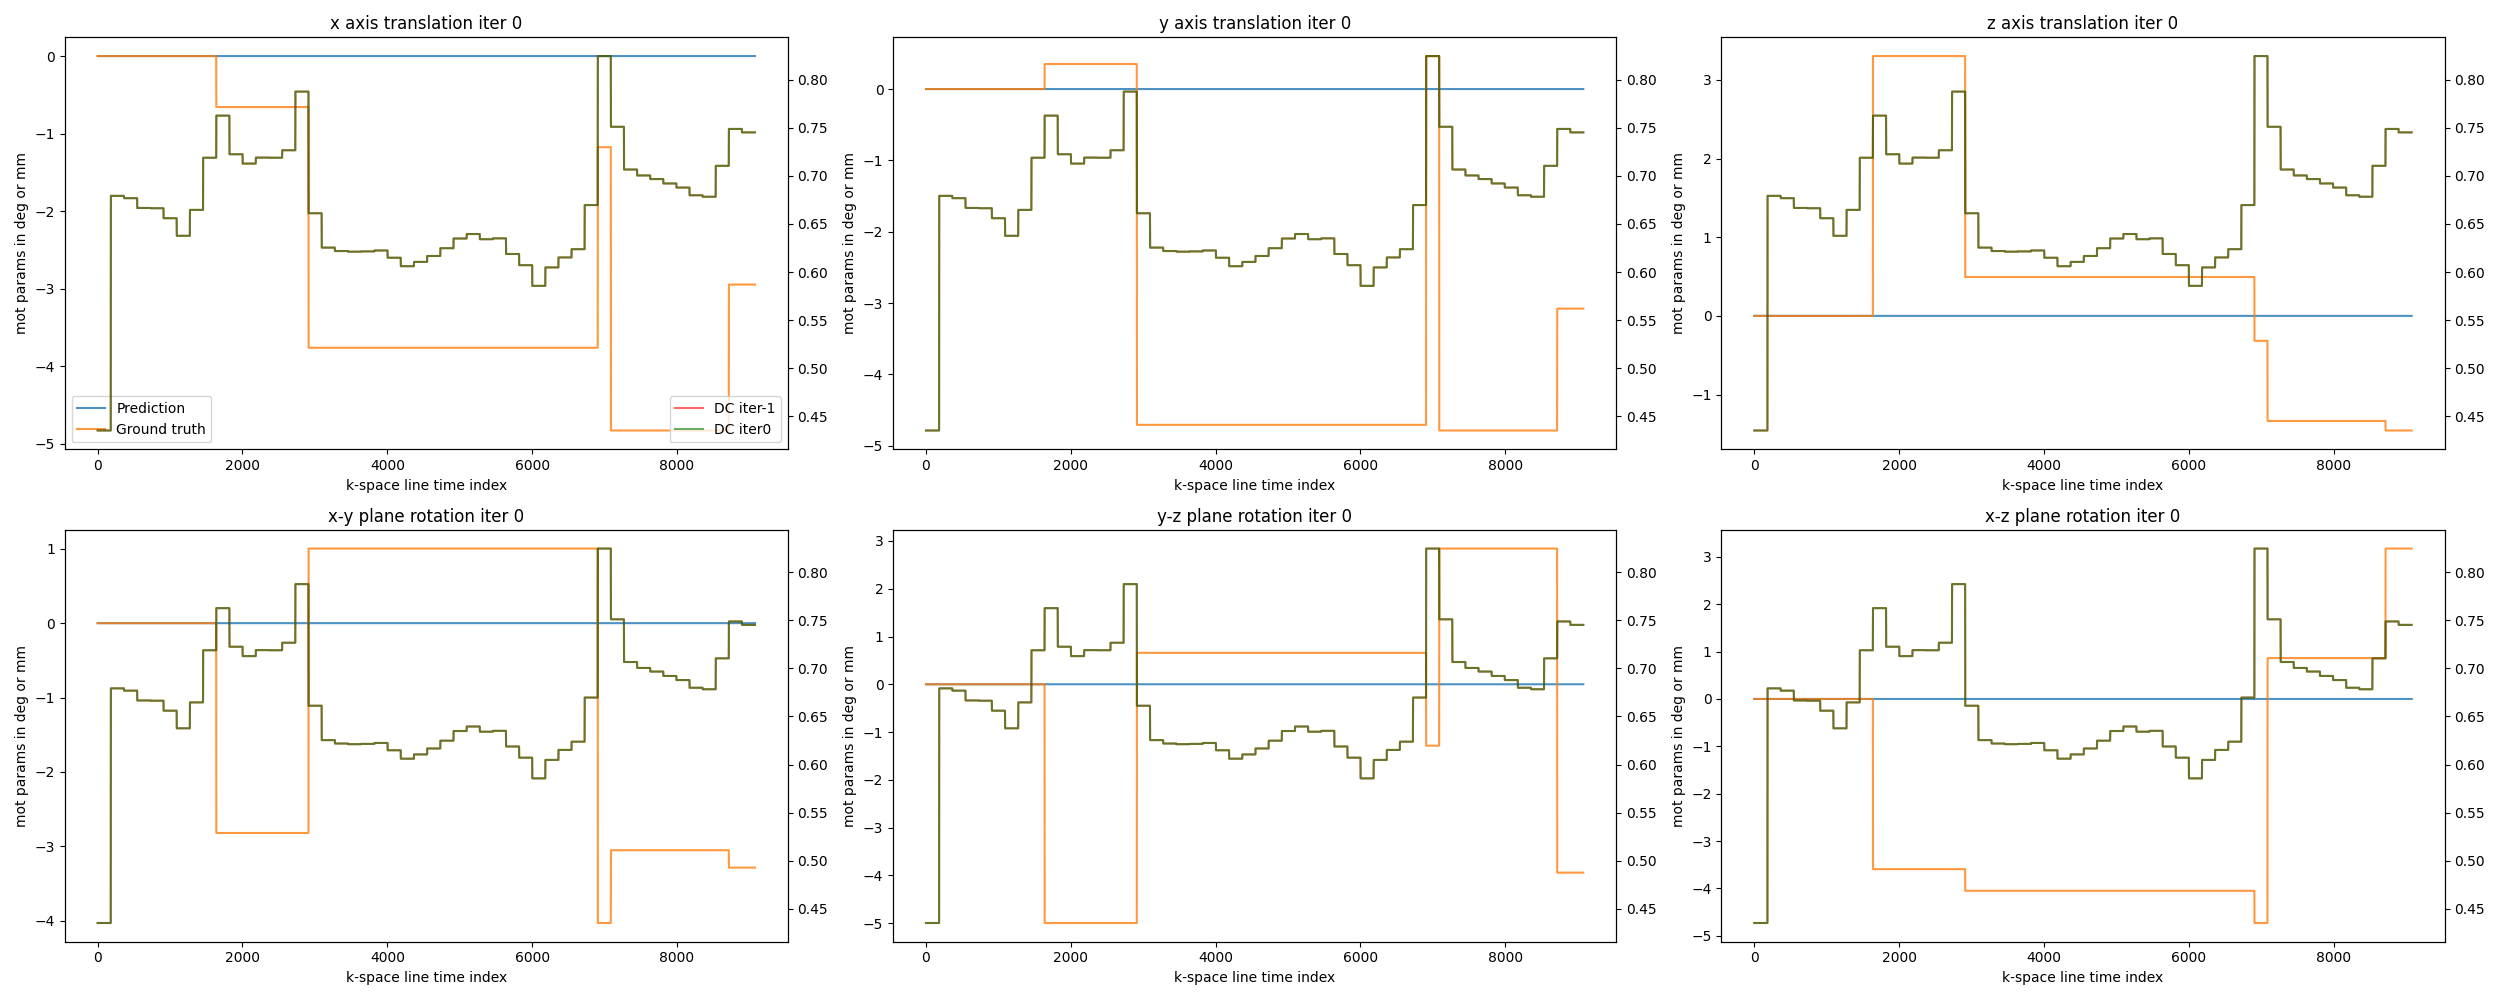

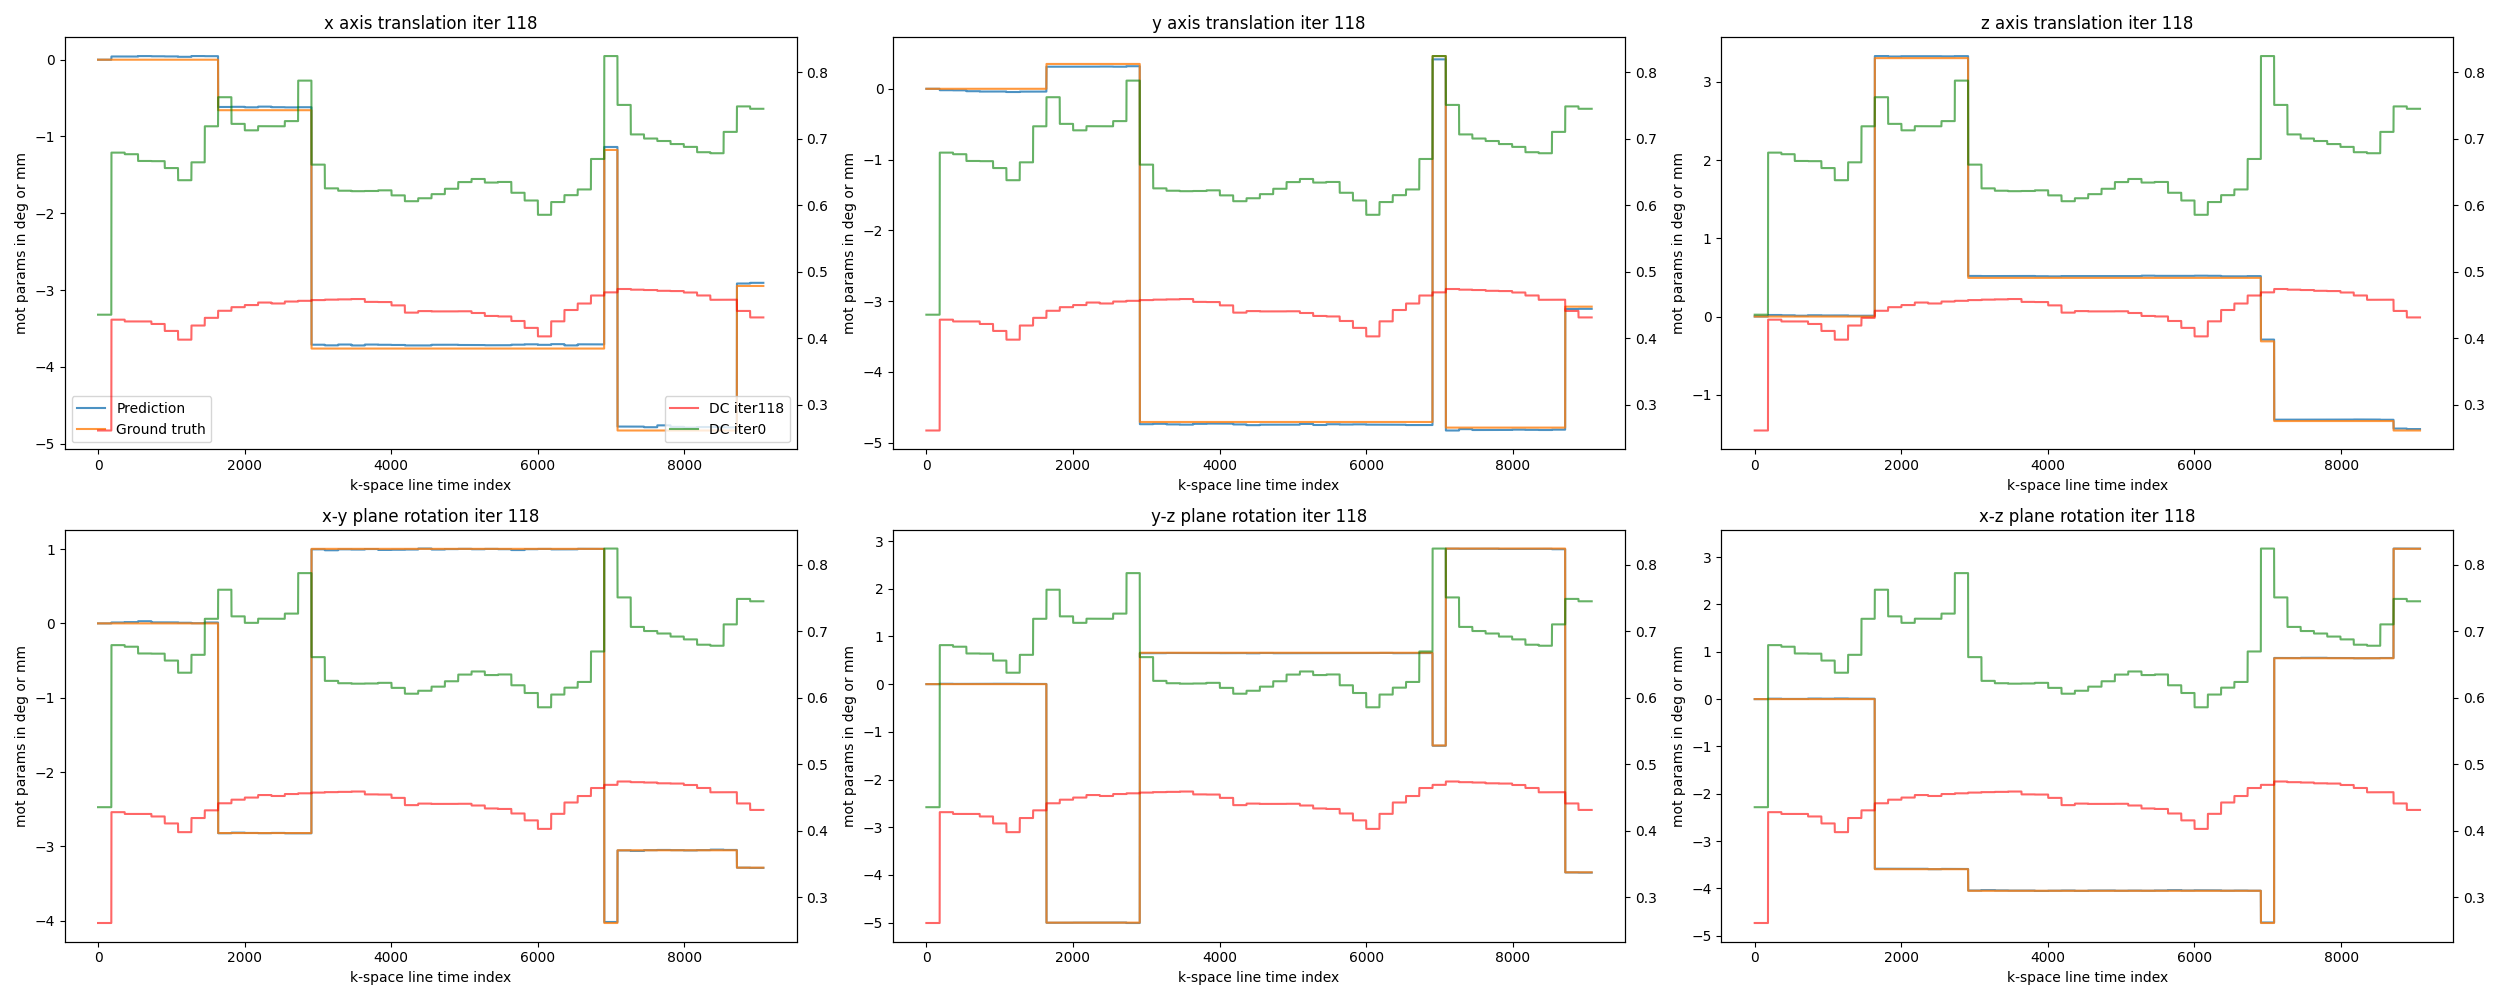

In [7]:
from PIL import Image
from IPython.display import display

phase = args.L1min_on_TTT_load_from_phase

step0_mot_params = Image.open(os.path.join(args.TTT_results_path, "motion_param_figures_phase0", "motion_pred_params_0_axind_2.png"))
display(step0_mot_params)

with open(os.path.join(args.TTT_results_path_numerical,f"phase{phase}","final_result_dict.pkl"),'rb') as fn: best_step = pickle.load(fn)["TTT_best_step"]

stepbest_mot_params = Image.open(os.path.join(args.TTT_results_path, f"motion_param_figures_phase{phase}", f"motion_pred_params_best_step_{best_step}_phase{phase}.png"))
display(stepbest_mot_params)

Display zero-filled motion corrupted images vs. final reconstructions based on L1-minimization with motion parameters estimated by MotionTTT

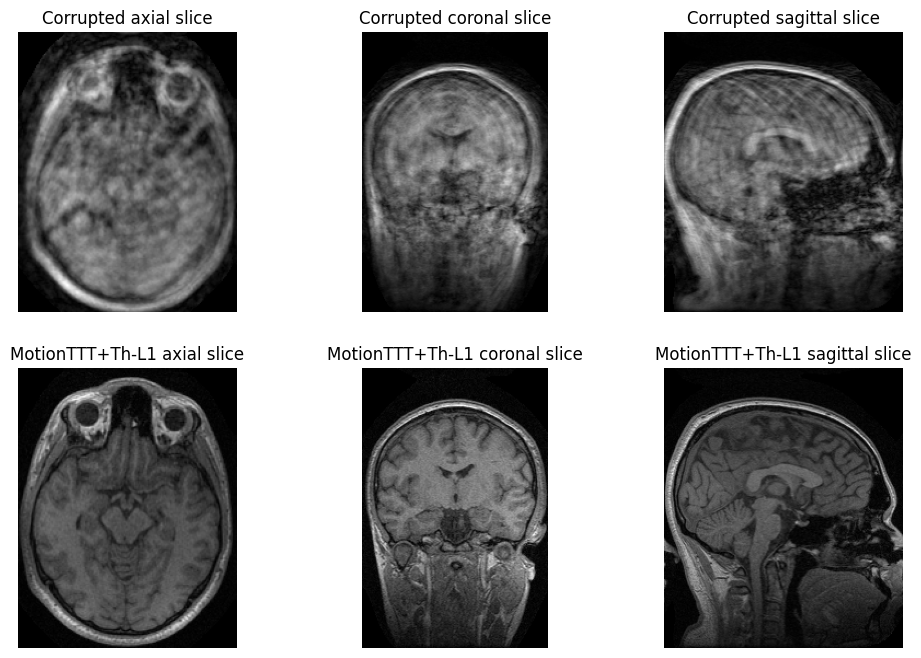

In [8]:
from matplotlib import pyplot as plt

zf_corrupted_mid_slice_axial = Image.open(os.path.join(args.TTT_results_path, "slice_images", "masked_corrupted_img_axial_128.png"))
zf_corrupted_mid_slice_coronal = Image.open(os.path.join(args.TTT_results_path, "slice_images", "masked_corrupted_img_coronal_109.png"))
zf_corrupted_mid_slice_sagittal = Image.open(os.path.join(args.TTT_results_path, "slice_images", "masked_corrupted_img_sagittal_85.png"))

MotionTTT_L1_mid_slice_axial = Image.open(os.path.join(args.L1min_results_path, "slice_images", "recon_min_reconDC_loss_img_axial_128.png"))
MotionTTT_L1_mid_slice_coronal = Image.open(os.path.join(args.L1min_results_path, "slice_images", "recon_min_reconDC_loss_img_coronal_109.png"))
MotionTTT_L1_mid_slice_sagittal = Image.open(os.path.join(args.L1min_results_path, "slice_images", "recon_min_reconDC_loss_img_sagittal_85.png"))

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs[0,0].imshow(zf_corrupted_mid_slice_axial)
axs[0,0].set_title("Corrupted axial slice")
axs[0,0].axis('off')
axs[0,1].imshow(zf_corrupted_mid_slice_coronal.rotate(-90, expand=True))
axs[0,1].set_title("Corrupted coronal slice")
axs[0,1].axis('off')
axs[0,2].imshow(zf_corrupted_mid_slice_sagittal.rotate(-90, expand=True))
axs[0,2].set_title("Corrupted sagittal slice")
axs[0,2].axis('off')
axs[1,0].imshow(MotionTTT_L1_mid_slice_axial)
axs[1,0].set_title("MotionTTT+Th-L1 axial slice")
axs[1,0].axis('off')
axs[1,1].imshow(MotionTTT_L1_mid_slice_coronal.rotate(-90, expand=True))
axs[1,1].set_title("MotionTTT+Th-L1 coronal slice")
axs[1,1].axis('off')
axs[1,2].imshow(MotionTTT_L1_mid_slice_sagittal.rotate(-90, expand=True))
axs[1,2].set_title("MotionTTT+Th-L1 sagittal slice")
axs[1,2].axis('off')
plt.show()
